In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
BASE_DIR = './17FlowerOxfordDataset'
N_CLUSTERS = 200
RANDOM_STATE = 42

In [4]:
def extract_sift_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return descriptors

In [5]:
def load_dataset(base_dir):
    data = []
    labels = []
    for label in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, label)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                descriptors = extract_sift_features(img_path)
                if descriptors is not None:
                    data.append(descriptors)
                    labels.append(label)
    return data, labels

In [6]:
all_descriptors, labels = load_dataset(BASE_DIR)

In [7]:
all_descriptors_combined = np.vstack([desc for desc in all_descriptors if desc is not None])
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
kmeans.fit(all_descriptors_combined)

KMeans(n_clusters=200, random_state=42)

In [8]:
def compute_histograms(descriptor_list, kmeans_model, n_clusters):
    histograms = []
    for descriptors in tqdm(descriptor_list):
        if descriptors is not None:
            histogram = np.zeros(n_clusters)
            clusters = kmeans_model.predict(descriptors)
            for cluster_idx in clusters:
                histogram[cluster_idx] += 1
            histograms.append(histogram)
        else:
            histograms.append(np.zeros(n_clusters))
    return np.array(histograms)

In [9]:
histograms = compute_histograms(all_descriptors, kmeans, N_CLUSTERS)

100%|██████████| 1600/1600 [00:03<00:00, 417.67it/s]


In [10]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    histograms, encoded_labels, test_size=0.2, random_state=RANDOM_STATE
)

In [12]:
base_estimator = DecisionTreeClassifier(max_depth=15, random_state=RANDOM_STATE)
adaboost = AdaBoostClassifier(estimator=base_estimator, n_estimators=300, random_state=RANDOM_STATE)
adaboost.fit(X_train, y_train)

c:\Users\Angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=15,
                                                    random_state=42),
                   n_estimators=300, random_state=42)

In [13]:
y_pred = adaboost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [14]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

    bluebell       1.00      0.21      0.35        19
   buttercup       0.67      0.55      0.60        11
     cowslip       0.67      0.24      0.35        17
      crocus       0.53      0.40      0.46        20
    daffodil       0.75      0.27      0.40        22
       daisy       1.00      0.71      0.83        17
   dandelion       0.65      0.91      0.76        55
  fritillary       0.78      0.70      0.74        10
        iris       0.92      0.80      0.86        15
       pansy       0.73      0.79      0.76        14
        rose       0.80      0.25      0.38        16
    snowdrop       0.38      0.62      0.47        34
   sunflower       0.85      0.92      0.88        12
  tiger lily       0.67      0.71      0.69        14
       tulip       0.32      0.61      0.42        28
  windflower       0.91      0.62      0.74        16

    accuracy                           0.60       320
   

In [15]:
y_pred = adaboost.predict(X_test)

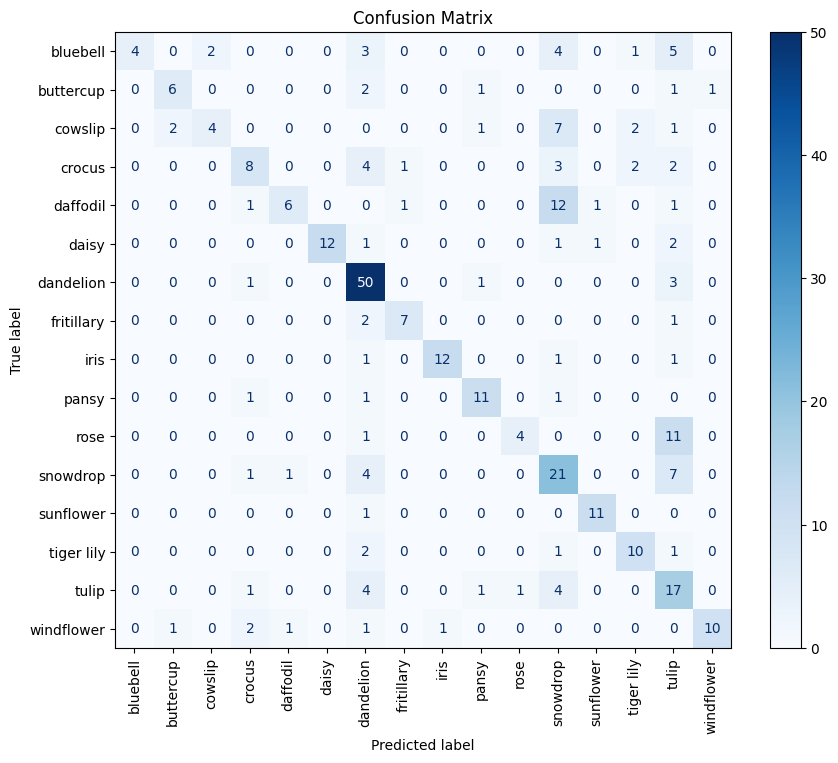

In [16]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')

plt.title("Confusion Matrix")
plt.savefig('sift-adaboost-confusionmatrix.png')
plt.show()

In [17]:
train_predictions = adaboost.predict(X_train)
test_predictions = adaboost.predict(X_test)

In [18]:
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Train Accuracy: 100.00%
Test Accuracy: 60.31%


c:\Users\Angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is 

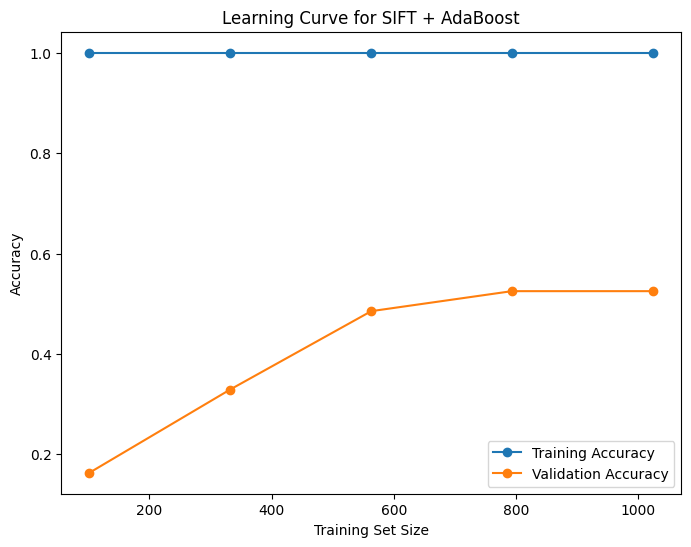

In [19]:
train_sizes, train_scores, val_scores = learning_curve(adaboost, X_train, y_train, cv=5, scoring='accuracy')
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy", marker='o')
plt.plot(train_sizes, val_mean, label="Validation Accuracy", marker='o')
plt.title("Learning Curve for SIFT + AdaBoost")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()